In [5]:
import torch
import matplotlib.pyplot as plt
import scipy.io
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [ ]:
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

In [ ]:
scipy.io.loadmat('train_data.mat')['train_data']

In [ ]:
# ------------Load data---------------------------------------------
print('Loading data..')
# --Loading the data; Normalizing image data
train_data = torch.div(torch.from_numpy(scipy.io.loadmat('train_data.mat')['train_data'].astype(np.float)),255) #--80% of total data; dim => [Nx3X32x32]
train_label1 = scipy.io.loadmat('train_label.mat')['train_label'] #--dim => [Nx1]
val_data = torch.div(torch.from_numpy(scipy.io.loadmat('val_data.mat')['val_data'].astype(np.float)),255)  #--10% of total data
val_label1 = scipy.io.loadmat('val_label.mat')['val_label']
test_data = torch.div(torch.from_numpy(scipy.io.loadmat('test_data.mat')['test_data'].astype(np.float)),255)  #--10% of total data
test_label = scipy.io.loadmat('test_label.mat')['test_label']

In [110]:
# ---Converting labels to 1-D tensor as ClassNLLCriterion expects the targets to be a 1-D tensor
train_label = torch.ByteTensor(train_label1.size)
val_label = torch.ByteTensor(val_label1.size)
for n1 in range(0,train_label1.size):
	train_label[n1] = train_label1[n1][0]-1

for n2 in range(0,val_label1.size):
  if(val_label1[n2][0]!=0): val_label[n2] = val_label1[n2][0]-1
  else: val_label[n2] = 0    
    # val_label[n2]=val_label[n2]-1

# train_label1 = nil
# val_label1 = nil
# collectgarbage()

In [112]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [133]:
# ------------Load model and initialize parameters---------------------
model = LeNet()
print(model)
model.to(device)
criterion = nn.NLLLoss()

LR = 0.001 #--Learning rate
epochs = 50  #--Number of epochs
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [134]:
# ------------Train model-------------------------------------------------
data_sz = len(train_data)
train_err = torch.zeros(1,epochs)
val_err = torch.zeros(1,epochs)
for n in range(1,epochs):	
  print('Epoch =', n)
  err = 0
  for i in range(1,data_sz):
    # -- feed data to the neural network and the criterion 
    data = train_data[i:i+1,:,:,:].to(device)
    target = train_label[i:i+1].to(device)
    model.train()
    # -- train over this example in 3 steps
    # -- (1) zero the accumulation of the gradients
    optimizer.zero_grad()
    output = model(data.float())
    loss=criterion(output,target)	  
    # -- (2) accumulate gradients
    loss.backward()
    # -- (3) update parameters with a 0.01 learning rate
    optimizer.step()
    err_train = loss
    err = err + err_train
    #  -- print(err)
    train_err[0,n] = err/data_sz
  # ----------------Finding validation error--------------------------
  model.eval()
  with torch.no_grad():
    val_output = model(val_data.to(device).float())	
    val_err[0,n] = criterion(val_output,val_label.to(device))

Epoch = 1
Epoch = 2
Epoch = 3
Epoch = 4
Epoch = 5
Epoch = 6
Epoch = 7
Epoch = 8
Epoch = 9
Epoch = 10
Epoch = 11
Epoch = 12
Epoch = 13
Epoch = 14
Epoch = 15
Epoch = 16
Epoch = 17
Epoch = 18
Epoch = 19
Epoch = 20
Epoch = 21
Epoch = 22
Epoch = 23
Epoch = 24
Epoch = 25
Epoch = 26
Epoch = 27
Epoch = 28
Epoch = 29
Epoch = 30
Epoch = 31
Epoch = 32
Epoch = 33
Epoch = 34
Epoch = 35
Epoch = 36
Epoch = 37
Epoch = 38
Epoch = 39
Epoch = 40
Epoch = 41
Epoch = 42
Epoch = 43
Epoch = 44
Epoch = 45
Epoch = 46
Epoch = 47
Epoch = 48
Epoch = 49


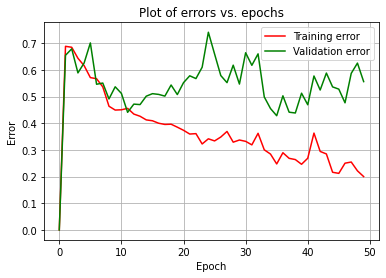

In [135]:
# ------------Plot performance------------------------------------------
plt.plot(train_err[0].detach().cpu().numpy(), color='r', label='Training error')
plt.plot(val_err[0].detach().cpu().numpy(), color='g', label='Validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.grid(True)
plt.title('Plot of errors vs. epochs')
plt.legend()
plt.show()

In [136]:
# -------------Test model------------------------------------------------
sample_test = test_data[5:15,:,:,:].to(device).float()
sample_label = test_label[5:15]-1
pred = torch.exp(model(sample_test))
pred_val,pred_class = torch.max(pred,1)
# -------------Printing results---------------------------------------
print('Predicted class...')
print(pred_class.numpy()) #-- predicted class
print('Ground truth label...')
print(np.transpose(sample_label)[0]) #-- goundtruth class

Predicted class...
[1 1 1 1 0 1 1 0 1 1]
Ground truth label...
[0 1 0 1 1 0 0 0 1 0]
